# Species Distribution Modellin in Python

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geowombat as gw # remote sensing and spatial operations
import geopandas as gpd

import dask
import joblib

import matplotlib.pyplot as plt
import os
import glob

In [2]:
%matplotlib inline

In [3]:
from dask.distributed import Client

client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/rvalavi/Documents/SDM_with_Python/dask-worker-space/worker-u_e79vc6', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/rvalavi/Documents/SDM_with_Python/dask-worker-space/worker-9eaccrc3', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/rvalavi/Documents/SDM_with_Python/dask-worker-space/worker-om87s_wu', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/rvalavi/Documents/SDM_with_Python/dask-worker-space/worker-7q6rr9zc', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 7.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39475,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 7.48 GiB
Comm: tcp://127.0.0.1:40717,Total threads: 3
Dashboard: http://127.0.0.1:43351/status,Memory: 1.87 GiB
Nanny: tcp://127.0.0.1:35547,


### *Listing raster layers*

In [4]:
rlist = glob.glob("Rasters/*.tif")
rlist

['Rasters/tempann.tif',
 'Rasters/vegsys.tif',
 'Rasters/solrad.tif',
 'Rasters/topo.tif',
 'Rasters/raindq.tif',
 'Rasters/cti.tif',
 'Rasters/mi.tif',
 'Rasters/soildepth.tif',
 'Rasters/rugged.tif',
 'Rasters/rainann.tif',
 'Rasters/soilfert.tif',
 'Rasters/tempmin.tif',
 'Rasters/disturb.tif']

In [5]:
names = [i[8:-4] for i in rlist]
names[0:3]

['tempann', 'vegsys', 'solrad']

### *Reading occurrence points*

In [6]:
# import point data
points = pd.read_csv("Records/train_po/NSWtrain_po.csv")
occ = points[points["spid"] == "nsw14"]
occ = occ[['occ', 'x', 'y']]
occ.shape

(315, 3)

In [7]:
geo_occ = gpd.GeoDataFrame(occ, geometry=gpd.points_from_xy(occ.x, occ.y))
geo_occ.head()

,occ,x,y,geometry
1149,1,153.4879,-28.1642,POINT (153.48790 -28.16420)
1150,1,153.4838,-28.1651,POINT (153.48380 -28.16510)
1151,1,153.4930,-28.1696,POINT (153.49300 -28.16960)
1152,1,152.5070,-28.2522,POINT (152.50700 -28.25220)
1153,1,152.4990,-28.2567,POINT (152.49900 -28.25670)


### *Generating random background samples*

In [8]:
from shapely.geometry import Point

def random_points_in_polygon(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds.values[0]
    x = np.random.uniform(minx, maxx, number)
    y = np.random.uniform(miny, maxy, number)
    
    df = pd.DataFrame()
    df['geometry'] = list(zip(x,y))
    df['geometry'] = df['geometry'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='geometry')
    
    Sjoin = gpd.tools.sjoin(gdf_points, polygon, predicate="within", how='left')

    # Keep points in "myPoly"
    pnts_in_poly = gdf_points[Sjoin.index_right==0]

    return pnts_in_poly

In [9]:
# read the border file
border = gpd.read_file("nsw.gpkg")

In [10]:
bg = random_points_in_polygon(border, 3_000)
bg.shape

(1487, 1)

In [11]:
bg['occ'] = 0
bg.head()

,geometry,occ
0,POINT (151.18232 -31.26933),0
1,POINT (152.40166 -31.10238),0
3,POINT (152.91376 -28.34845),0
7,POINT (151.13678 -31.08892),0
9,POINT (151.92109 -30.65342),0


<AxesSubplot:>

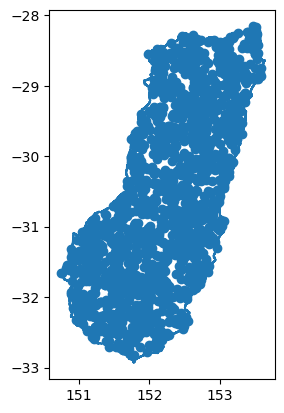

In [12]:
fig, ax = plt.subplots()

border.boundary.plot(ax=ax)
bg.plot(ax=ax)

### *Combine occurrence and background sample*

In [13]:
samples = pd.concat([geo_occ[['occ', 'geometry']], bg])
samples.head()

,occ,geometry
1149,1,POINT (153.48790 -28.16420)
1150,1,POINT (153.48380 -28.16510)
1151,1,POINT (153.49300 -28.16960)
1152,1,POINT (152.50700 -28.25220)
1153,1,POINT (152.49900 -28.25670)


In [14]:
samples.groupby('occ').count()

,geometry
occ,
0,1487
1,315


In [15]:
# save to file
samples.to_file('occurrence.gpkg', driver='GPKG', layer='name')

### *Extrating raster values for model training*

In [16]:
%%time
with gw.open(rlist, chunks=(1800, 1800)) as src:
    train_gdf = src.gw.extract('occurrence.gpkg', time_names=names, band_names=None)

CPU times: user 870 ms, sys: 144 ms, total: 1.01 s
Wall time: 2.84 s


In [17]:
train_gdf

,occ,geometry,id,tempann_1,vegsys_1,solrad_1,topo_1,raindq_1,cti_1,mi_1,soildepth_1,rugged_1,rainann_1,soilfert_1,tempmin_1,disturb_1
0,1,POINT (153.48790 -28.16420),0,200,5,89,-1,216,1339,88,1139,11,1590,2,85,3
1,1,POINT (153.48380 -28.16510),1,199,5,89,-3,216,1439,88,1149,15,1592,2,84,3
2,1,POINT (153.49300 -28.16960),2,200,5,89,-1,222,1629,89,1159,1,1594,2,86,3
3,1,POINT (152.50700 -28.25220),3,159,2,86,-3,222,1259,92,1080,28,1580,2,45,2
4,1,POINT (152.49900 -28.25670),4,158,2,88,-3,222,1279,91,1110,51,1568,2,44,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,0,POINT (152.42065 -31.92114),1797,174,9,87,-1,174,1312,77,1080,1,1054,3,44,4
1798,0,POINT (151.75744 -31.62816),1798,146,2,64,28,150,1169,88,980,84,1050,2,3,3
1799,0,POINT (151.87608 -31.87531),1799,155,2,76,-6,156,1349,87,980,65,1140,2,25,3
1800,0,POINT (152.75872 -30.30694),1800,141,9,86,12,288,1159,93,1169,20,1964,2,-4,4


<AxesSubplot:>

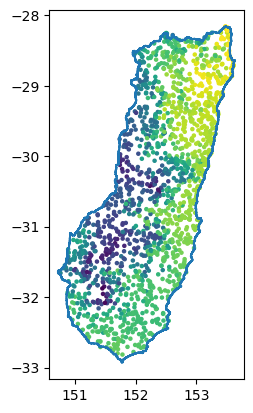

In [18]:
base = border.boundary.plot()
train_gdf.plot(ax=base, column='tempann_1', markersize=5)

In [19]:
# select a few variables and rename them
train_df = train_gdf[['tempann_1', 'solrad_1', 'topo_1', 'raindq_1', 'cti_1', 'mi_1', 'soildepth_1', 'rugged_1', 'rainann_1', 'soilfert_1', 'tempmin_1']]
col_names = {i:i[0:-2] for i in train_df.columns}
X = train_df.rename(columns=col_names)
X.head()

,tempann,solrad,topo,raindq,cti,mi,soildepth,rugged,rainann,soilfert,tempmin
0,200,89,-1,216,1339,88,1139,11,1590,2,85
1,199,89,-3,216,1439,88,1149,15,1592,2,84
2,200,89,-1,222,1629,89,1159,1,1594,2,86
3,159,86,-3,222,1259,92,1080,28,1580,2,45
4,158,88,-3,222,1279,91,1110,51,1568,2,44


In [20]:
y = train_gdf['occ']
y.unique()

array([1, 0])

## *Model fitting*

In [22]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [21]:
from dask_ml.wrappers import ParallelPostFit

https://examples.dask.org/machine-learning/scale-scikit-learn.html#:~:text=Distributed%20Training,-Scikit%2Dlearn%20uses&text=Alternatively%2C%20Scikit%2DLearn%20can%20use,models%20on%20medium%2Dsized%20datasets.

In [23]:
rf_model = ParallelPostFit(RandomForestClassifier(n_jobs=-1))

In [24]:
cv = StratifiedKFold(n_splits=5)

In [25]:
np.floor(np.sqrt(X.shape[1]))

3.0

Use `estimator__param` instead of param when using `ParallelPostFit` for distributed prediction

In [29]:
params = {'estimator__max_features': [2, 3, 4, 5], 
          'estimator__n_estimators':[500, 1000],
          'estimator__class_weight':['balanced']}

In [30]:
gridsearch = GridSearchCV(rf_model, cv=cv, scoring='roc_auc', param_grid=params, n_jobs=4, verbose=1)

In [31]:
%%time
gridsearch.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: user 12.5 s, sys: 4.72 s, total: 17.3 s
Wall time: 1min 13s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=ParallelPostFit(estimator=RandomForestClassifier(n_jobs=-1)),
             n_jobs=4,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_features': [2, 3, 4, 5],
                         'estimator__n_estimators': [500, 1000]},
             scoring='roc_auc', verbose=1)

In [32]:
gridsearch.best_estimator_

ParallelPostFit(estimator=RandomForestClassifier(class_weight='balanced',
                                                 max_features=3,
                                                 n_estimators=500, n_jobs=-1))

In [34]:
gridsearch.best_score_

0.782171471470502

In [35]:
# predict on the training samples
train_predicted = gridsearch.predict_proba(X)
train_predicted.shape

(1802, 2)

In [36]:
train_predicted

array([[0.236, 0.764],
       [0.158, 0.842],
       [0.284, 0.716],
       ...,
       [0.942, 0.058],
       [0.752, 0.248],
       [1.   , 0.   ]])

In [37]:
train_gdf['prediction'] = train_predicted[:,1]

<AxesSubplot:>

<Figure size 200x200 with 0 Axes>

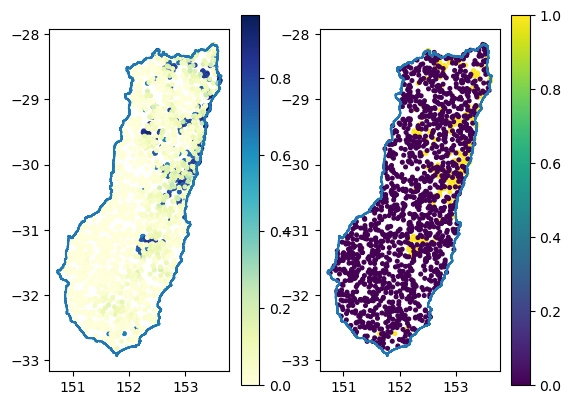

In [38]:
plt.figure(figsize=(2,2))
fig, (ax1, ax2) = plt.subplots(1,2)

base = border.boundary.plot(ax=ax1)
train_gdf.plot(ax=base, column='prediction', markersize=7, cmap='YlGnBu', legend=True)

base = border.boundary.plot(ax=ax2)
train_gdf.plot(ax=base, column='occ', markersize=7, legend=True)

### *Predicting to an xarray*

In [39]:
# rxr.open_rasterio('Rasters/tempann.tif', chunks={'x':1800, 'y':1800}).astype(np.float16)

In [40]:
name_var = xr.Variable('name', names)
r = xr.concat([rxr.open_rasterio(i, chunks={'x':900, 'y':900}) for i in rlist], dim=name_var)
# r = r.to_dataset('name').squeeze() # drop unused dimention
r = r.squeeze()
r

<xarray.DataArray (name: 13, y: 5390, x: 3378)>
dask.array<getitem, shape=(13, 5390, 3378), dtype=int32, chunksize=(1, 900, 900), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 150.6 150.7 150.7 150.7 ... 153.7 153.7 153.7 153.7
  * y            (y) float64 -28.1 -28.1 -28.1 -28.11 ... -32.95 -32.95 -32.95
    spatial_ref  int64 0
  * name         (name) <U9 'tempann' 'vegsys' 'solrad' ... 'tempmin' 'disturb'
Attributes:
    STATISTICS_MAXIMUM:  201
    STATISTICS_MEAN:     159.29271255618
    STATISTICS_MINIMUM:  84
    STATISTICS_STDDEV:   25.150546185294
    _FillValue:          255.0
    scale_factor:        1.0
    add_offset:          0.0

In [41]:
X.columns

Index(['tempann', 'solrad', 'topo', 'raindq', 'cti', 'mi', 'soildepth',
       'rugged', 'rainann', 'soilfert', 'tempmin'],
      dtype='object')

In [42]:
Xr = r.sel(name=X.columns).stack(z=['x', 'y']).data.T
Xr

dask.array<transpose, shape=(18207420, 11), dtype=int32, chunksize=(808500, 1), chunktype=numpy.ndarray>

In [51]:
Xr = r.sel(name=X.columns).stack(z=['x', 'y']).T

In [43]:
Xr

dask.array<transpose, shape=(18207420, 11), dtype=int32, chunksize=(808500, 1), chunktype=numpy.ndarray>

In [ ]:
%%time
# predict to dask dataframe of the rasters in the cluster
# with joblib.parallel_backend('dask'):
raster_pred = gridsearch.predict_proba(Xr)

In [ ]:
plt.figure(figsize=(3,4))
r.tempann[0::10, 0::10].plot()

In [38]:
dt = r.tempann.to_dataframe()
dt

band  spatial_ref  tempann
y          x                                     
-28.102708 150.649397     1            0      255
           150.650296     1            0      255
           150.651196     1            0      255
           150.652095     1            0      255
           150.652994     1            0      255
...                     ...          ...      ...
-32.949154 153.682810     1            0      255
           153.683710     1            0      255
           153.684609     1            0      255
           153.685508     1            0      255
           153.686408     1            0      255

[18207420 rows x 3 columns]

In [39]:
dask_df = r.to_dask_dataframe()

In [40]:
list(X.columns)

['tempann',
 'solrad',
 'topo',
 'raindq',
 'cti',
 'mi',
 'soildepth',
 'rugged',
 'rainann',
 'soilfert',
 'tempmin']

In [41]:
Xr = dask_df[list(X.columns)]
Xr

,tempann,solrad,topo,raindq,cti,mi,soildepth,rugged,rainann,soilfert,tempmin
npartitions=24,,,,,,,,,,,
0,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32
760050,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
17450748,...,...,...,...,...,...,...,...,...,...,...
18207419,...,...,...,...,...,...,...,...,...,...,...


In [42]:
%%time
# predict to dask dataframe of the rasters in the cluster
with joblib.parallel_backend('dask', scatter=[Xr]):
    raster_pred = gridsearch.predict_proba(Xr)

CPU times: user 51min 8s, sys: 7min 49s, total: 58min 58s
Wall time: 7min 6s


In [52]:
raster_pred.shape, r.tempann.shape

((18207420, 2), (5390, 3378))

In [53]:
raster_pred[:,1]

array([0.167, 0.167, 0.167, ..., 0.167, 0.167, 0.167])

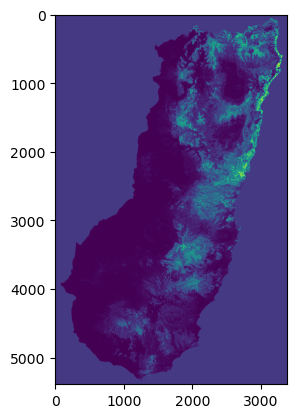

In [54]:
plt.imshow(raster_pred[:,1].reshape(r.tempann.shape))

## Modelling test with GeoWombat [currently not working on local cluster]

In [48]:
from geowombat.ml import predict

In [33]:
Xr.columns

Index(['tempann', 'solrad', 'topo', 'raindq', 'cti', 'mi', 'soildepth',
       'rugged', 'rainann', 'soilfert', 'tempmin'],
      dtype='object')

In [34]:
selected_vars = ['Rasters/' + i + '.tif' for i in Xr.columns]
selected_vars

['Rasters/tempann.tif',
 'Rasters/solrad.tif',
 'Rasters/topo.tif',
 'Rasters/raindq.tif',
 'Rasters/cti.tif',
 'Rasters/mi.tif',
 'Rasters/soildepth.tif',
 'Rasters/rugged.tif',
 'Rasters/rainann.tif',
 'Rasters/soilfert.tif',
 'Rasters/tempmin.tif']

In [36]:
samples = samples.set_crs('epsg:4326')

In [37]:
samples.crs# is None

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
%%time
with gw.open(selected_vars, chunks=(1800, 1800)) as src:
    y = fit_predict(src, gridsearch, samples, col='occ')
    print(y)

In [80]:
# close the cluster
client.close()

In [56]:
from dask.distributed import LocalCluster

In [ ]:
with LocalCluster(n_workers=4,
                  threads_per_worker=2,
                  scheduler_port=0,
                  processes=False,
                  memory_limit='8GB') as cluster:
    
    with gw.open(selected_vars, chunks=(1800, 1800)) as src:
        y = predict(src, X, gridsearch)
        # df = gw.extract(src, samples, use_client=True, address=cluster)

In [24]:
from geowombat.ml import fit, predict, fit_predict
from sklearn.model_selection import GridSearchCV, KFold
from sklearn_xarray.model_selection import CrossValidatorWrapper

rf_model = RandomForestClassifier()

cv = StratifiedKFold(n_splits=5)

params = {'max_features': [2, 3, 4, 5], 
          'n_estimators':[500, 1000],
          'class_weight':['balanced']}

gridsearch = GridSearchCV(rf_model, cv=cv, scoring='roc_auc', param_grid=params, n_jobs=4, verbose=1)
gridsearch

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'class_weight': ['balanced'],
                         'max_features': [2, 3, 4, 5],
                         'n_estimators': [500, 1000]},
             scoring='roc_auc', verbose=1)

In [23]:
samples

,occ,geometry
1149,1,POINT (153.48790 -28.16420)
1150,1,POINT (153.48380 -28.16510)
1151,1,POINT (153.49300 -28.16960)
1152,1,POINT (152.50700 -28.25220)
1153,1,POINT (152.49900 -28.25670)
...,...,...
2993,0,POINT (152.64874 -30.89738)
2995,0,POINT (153.30599 -29.01529)
2996,0,POINT (152.57166 -29.91630)
2997,0,POINT (151.79748 -32.54836)


In [ ]:
# with gw.config.update(ref_res=300):
with gw.open(selected_vars, chunks=(900, 900)) as src:
    X, Xy, clf = fit(src, gridsearch, samples, col="occ")

In [ ]:
gridsearch.fit(*Xy)

print(gridsearch.best_score_)

clf.set_params(**gridsearch.best_params_)
y1 = predict(src, X, clf)

y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)